In [1]:
import sys
from pathlib import Path
import os
import warnings
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)

import numpy as np
from scipy import ndimage, signal, stats, interpolate, optimize
import skimage.io as skio
from skimage import filters, transform, morphology
from tifffile import imsave
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize
from spikecounter import utils
from sklearn.decomposition import PCA

biopubs_style = os.path.join(SPIKECOUNTER_PATH, "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)

In [2]:
expt_name = "20220123_drbj009_excitability_test"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure4/", expt_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"
os.makedirs(os.path.join(rootdir, "analysis"), exist_ok=True)

In [3]:
expt_data = utils.process_experiment_metadata(pd.read_csv(rootdir/"analysis"/"experiment_data.csv"),
                                              regexp_dict={
                                                "embryo": "(?<=DRBJ009_)E\d+"
                                            })

In [4]:
snap_data = utils.process_experiment_metadata(pd.read_csv(rootdir/"Snaps/analysis"/"experiment_data.csv"),
                                             regexp_dict={
                                                "embryo": "(?<=DRBJ009_)E\d+"
                                            })

In [5]:
snap_data = snap_data[snap_data["file_name"].str.contains("DRBJ009")]

In [6]:
expt_data = utils.match_experiments_to_snaps(expt_data, snap_data)

### Preprocess the data

132209DRBJ009_E32_10Hz

In [7]:
# file_name = "123953DRBJ009_E7_10Hz"
idx = -3
row = expt_data.iloc[idx]
file_name = row["file_name"]
img, metadata = images.load_image(rootdir, file_name, subfolder="corrected", trim=True)
snap = images.match_snap_to_data(skio.imread(rootdir/"Snaps"/row["snap_file"]), img.mean(axis=0))

/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:226: UserWarning: 1 frames dropped
  warnings.warn(f"{n_frames_dropped} frames dropped")


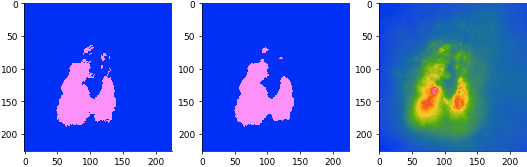

In [10]:
rough_mask = (snap > filters.threshold_local(snap, block_size=251, offset=0.1))*(snap > filters.threshold_otsu(snap))
d = morphology.disk(2)
mask = morphology.binary_closing(morphology.binary_opening(rough_mask, d))
fig1, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(rough_mask, interpolation="none")
axs[1].imshow(mask, interpolation="none")
axs[2].imshow(snap)

In [11]:
traces_dict, t = utils.traces_to_dict(metadata, trim=True)

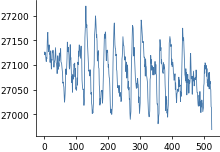

In [12]:
mean_intensity = img.mean(axis=0)
mean_trace = img.mean(axis=(1,2))
plt.plot(mean_trace)

In [13]:
dFF_img = images.get_image_dFF(img)

Ex trace

In [14]:
example_trace = images.extract_mask_trace(dFF_img, mask)

In [15]:
stims = np.diff(traces_dict["enable488"], append=False) == 1

In [21]:
yscale

array([0.038])

$1\%$
$\Delta F/F$


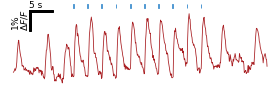

In [39]:
fig1, ax1 = visualize.plot_trace_with_stim_bars(example_trace, t[stims], 1.068,
                        0.1, 0.002, t=t, figsize=(5,1.5), trace_color="#A91F23", stim_color="#539AD3")
ax1.set_ylim(1.032, 1.07)
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
yscale = np.diff(ylim)[0]
scalebar_params = {
    "corner_x": xlim[0]+6,
    "corner_y": ylim[0]+yscale*0.9,
    "ampl_scale": yscale*0.25,
    "time_scale": 5,
    "fontsize": 9,
    "thickness": yscale*0.02,
    "xlabel_offset_y": 0.002,
    "xlabel_offset_x": 0,
    "ylabel_offset_x": -4,
    "ylabel_offset_y": 0.002,
    "ylabel": r"$%d\%%$" "\n" r"$\Delta F/F$"
}
visualize.plot_scalebars(ax1, scalebar_params, pct_f=True)
plt.savefig(output_datadir/"example_caoptopatch_no_rna.svg")

### Now try PCA
To find which regions are fluctuating due to the stimuli.

In [67]:
rd, gc = images.extract_region_data(dFF_img, np.ones((dFF_img.shape[1], dFF_img.shape[2])), 1)

In [68]:
pca = PCA(n_components=20)
pca.fit(rd)

PCA(n_components=20)

(<Figure size 864x4320 with 30 Axes>,
 array([[<AxesSubplot:title={'center':'PC 1 (Fraction Var:0.100)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 2 (Fraction Var:0.018)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 3 (Fraction Var:0.007)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 4 (Fraction Var:0.006)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 5 (Fraction Var:0.005)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 6 (Fraction Var:0.004)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 7 (Fraction Var:0.004)'}>,
         <AxesSubplot:title={'center':'PC Value'}>],
        [<AxesSubplot:title={'center':'PC 8 (Fraction Var:0.004)'}>,
         <AxesSubplot:title={'center':'

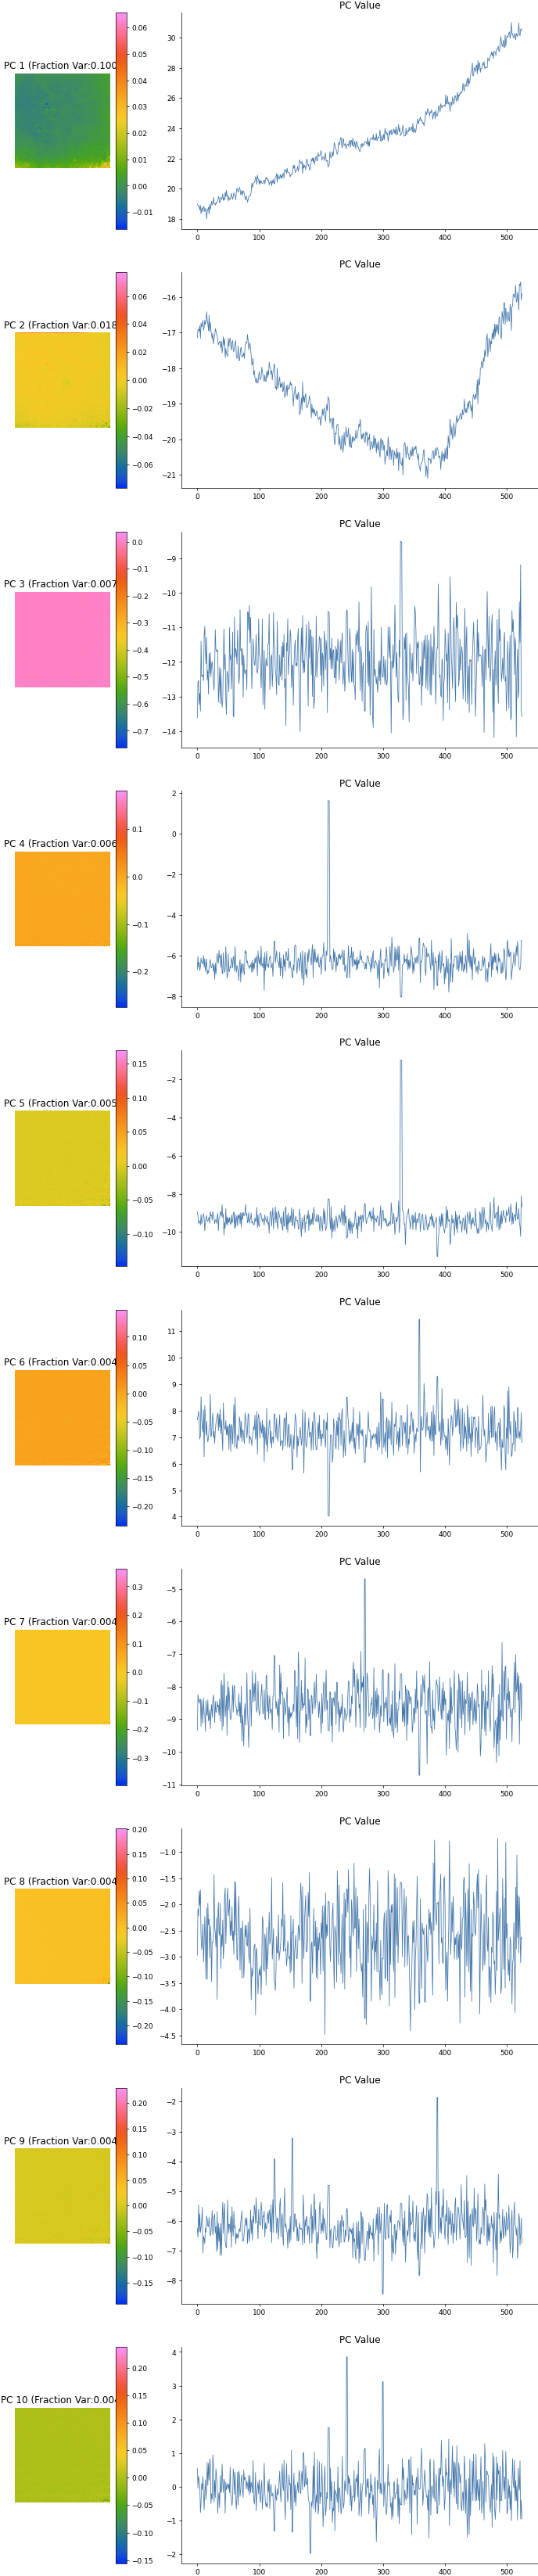

In [69]:
visualize.plot_pca_data(pca, rd, gc, n_components=10)

In [151]:
sta = np.mean(np.array(spike_images), axis=0)

In [154]:
utils.display_zstack(sta)

interactive(children=(IntSlider(value=12, description='z', max=24), Dropdown(description='c', options=('all', …

In [158]:
rd_sta, gc_sta = images.extract_region_data(sta, np.ones((sta.shape[1], sta.shape[2])), 1)
pca_sta = PCA(n_components=20)
pca_sta.fit(rd_sta)

PCA(n_components=20)

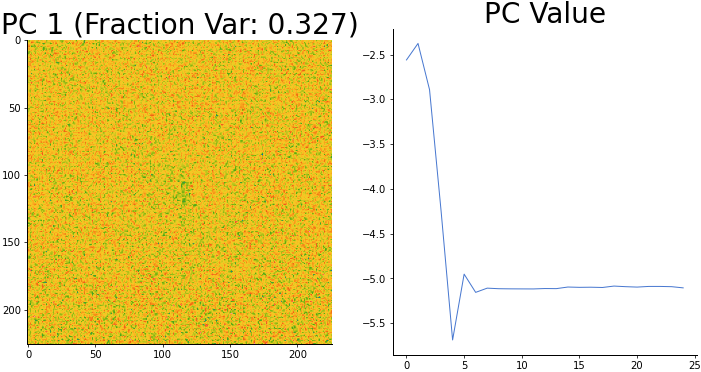

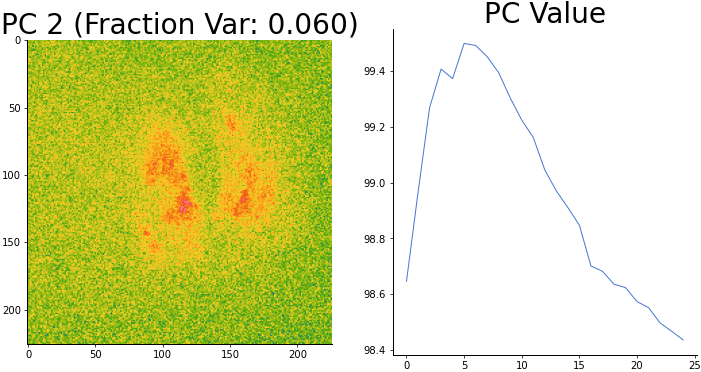

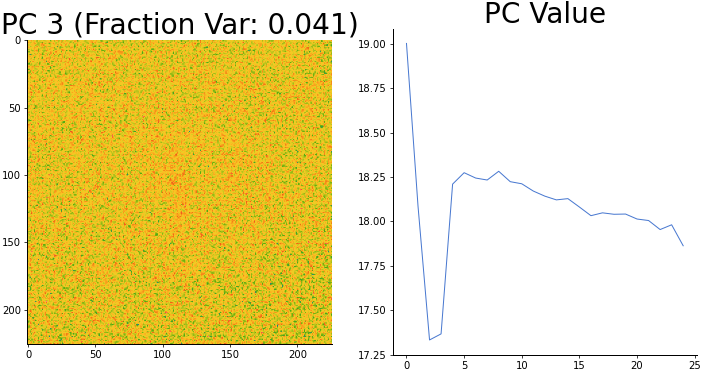

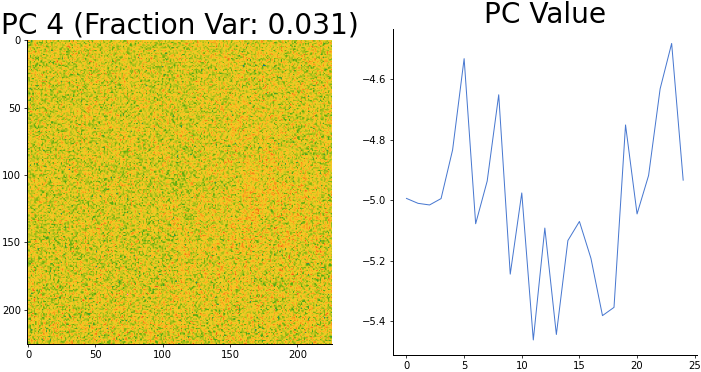

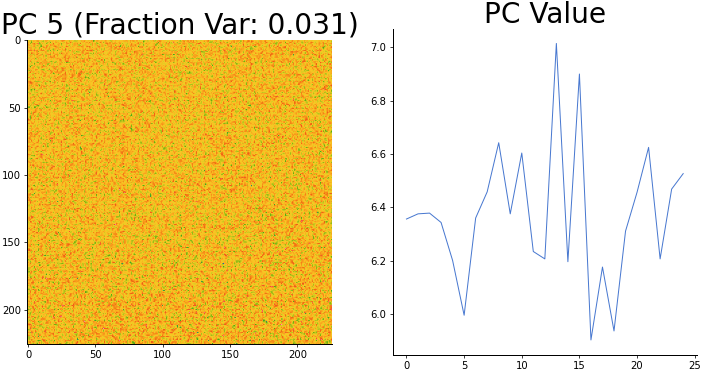

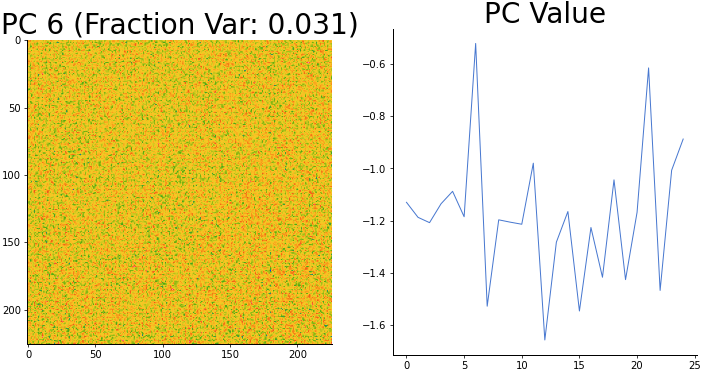

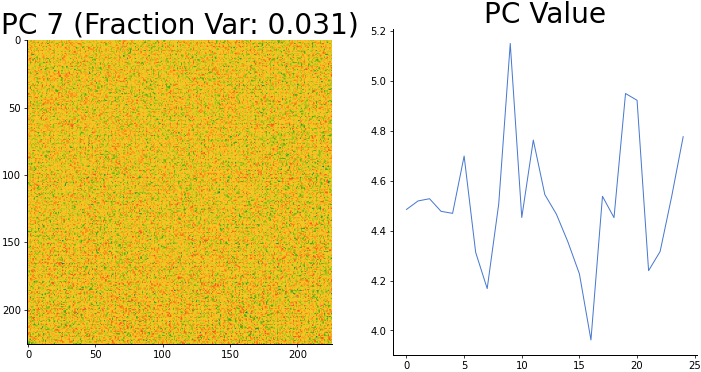

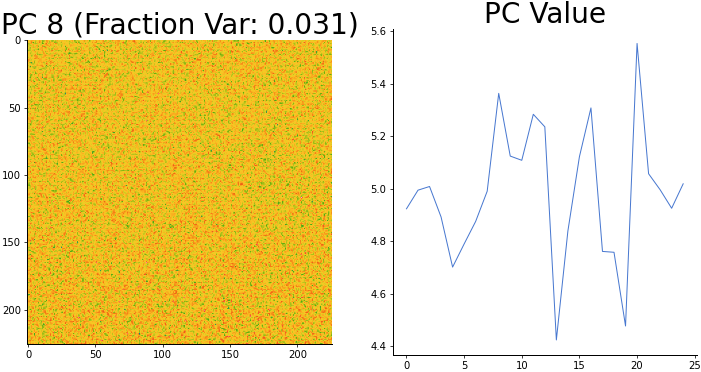

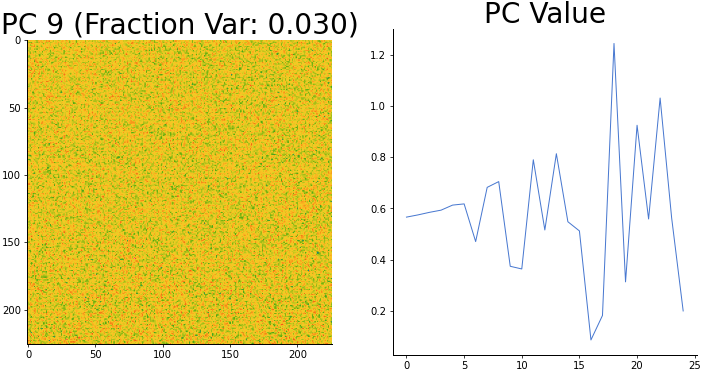

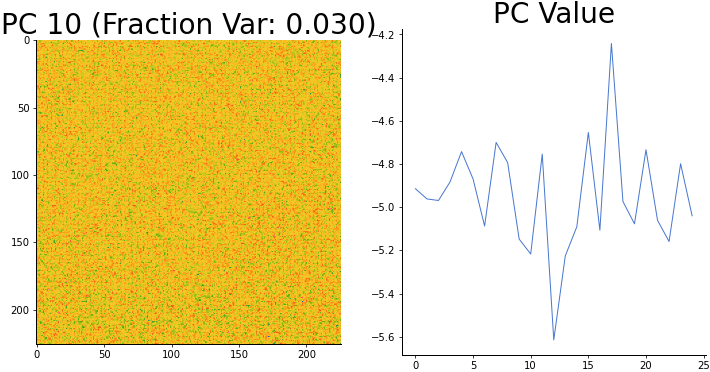

In [159]:
images.display_pca_data(pca_sta, rd_sta, gc_sta, n_components=10)

In [162]:
pca_img = pca_sta.components_[1].reshape((sta.shape[1], sta.shape[2]))

AttributeError: module 'skimage.filters' has no attribute 'butterworth'

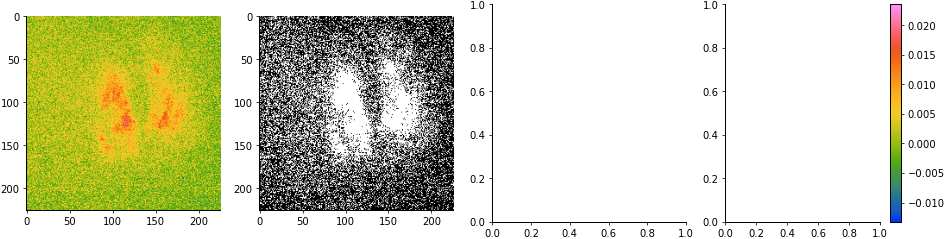

In [176]:
fig1, axes = plt.subplots(1,4, figsize=(16,4))
im = axes[0].imshow(pca_img)
plt.colorbar(im)
ot = filters.threshold_otsu(pca_img)
axes[1].imshow(pca_img> ot, cmap="gray")
smoothed_img = filters.butterworth(pca_img, hgih_pass=False)
axes[2].imshow(smoothed_img)
ot2 = filters.threshold_otsu(smoothed_img)
axes[3].imshow(smoothed_img>ot2, cmap="gray")

Text(0, 0.5, '$\\Delta F/F$')

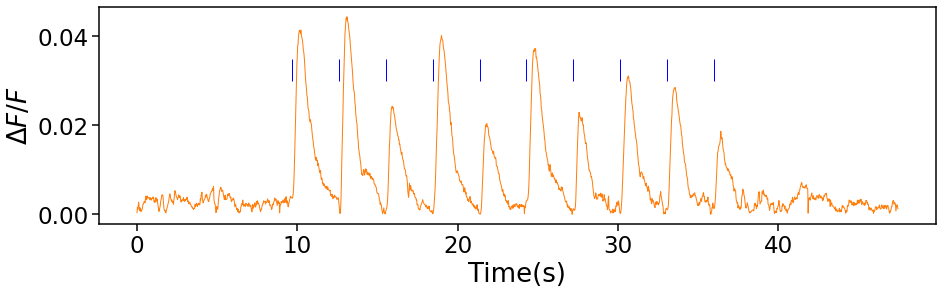

In [290]:
fig1, ax1 = plt.subplots(figsize=(15,4))
ax1.plot(np.arange(dFF_img.shape[0])/fs, dff_trace-np.min(dff_trace), color="C1")
for st in stims:
    r = patches.Rectangle((st, 0.03), 0.02, 0.005, color="blue")
    ax1.add_patch(r)
ax1.set_xlabel("Time(s)")
ax1.set_ylabel(r"$\Delta F/F$")

In [291]:
mask_edges = t_mask.astype(int)[1:] - t_mask.astype(int)[:-1]
rising_edges = mask_edges == 1
falling_edges = mask_edges == -1

In [315]:
sta_length = 70
offset = -3
# sta_length=240
# offset=-90
spike_traces = []
spike_images = []
# edge = np.argwhere(falling_edges).ravel()[0]
for edge in np.argwhere(falling_edges).ravel()[:-1]:
    spike_traces.append(dff_trace[edge+offset:edge+offset+sta_length])
    spike_images.append(dFF_img[edge+offset:edge+offset+sta_length,:,:])

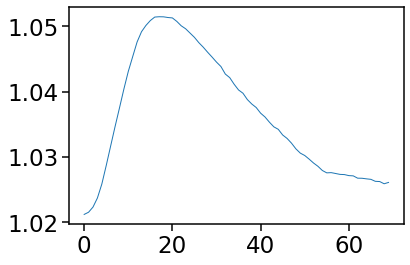

In [316]:
sta_trace = np.mean(np.array(spike_traces), axis=0)
plt.plot(sta_trace)

In [317]:
sta = np.mean(np.array(spike_images), axis=0)

In [318]:
nkx_sta = np.tile(nkx_downsample, (sta.shape[0], 1, 1))

In [ ]:
utils.display_zstack(sta[:,:,:, np.newaxis], c=0, pct_cutoffs=[5,99])

interactive(children=(IntSlider(value=34, description='z', max=69), Dropdown(description='c', options=('all', …

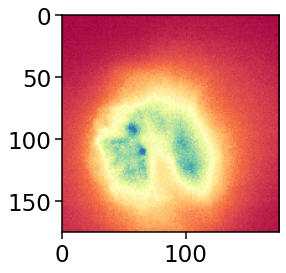

In [297]:
plt.imshow(nkx_downsample)

In [298]:
skio.imsave(os.path.join(rootdir, "analysis", filename, "sta.tif"), sta)

<ipython-input-298-6824ba1c47ce>:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211005_CaOptopatch_pre_activity_propagation//analysis/083035E4_posterior_stim/sta.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", filename, "sta.tif"), sta)


In [299]:
expttag = "E4_posterior_slow"

In [300]:
skio.imsave(os.path.join(rootdir, "analysis", "sta_%s.tif" %expttag), sta)
skio.imsave(os.path.join(rootdir, "analysis", "nkx_%s.tif" %expttag), nkx_sta)

<ipython-input-300-bdd49ae75fec>:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211005_CaOptopatch_pre_activity_propagation//analysis/sta_E4_posterior_slow.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", "sta_%s.tif" %expttag), sta)


In [301]:
skio.imsave(os.path.join(rootdir, "analysis", filename, "dFF.tif"), dFF_img)

<ipython-input-301-e2211c8d018c>:1: UserWarning: /n/holyscratch01/cohen_lab/bjia/20211005_CaOptopatch_pre_activity_propagation//analysis/083035E4_posterior_stim/dFF.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", filename, "dFF.tif"), dFF_img)


### Identify stim region

In [302]:
mask_edges = t_mask.astype(int)[1:] - t_mask.astype(int)[:-1]
rising_edges = mask_edges == 1

In [303]:
cropped_img = spatial_downsample[:end_idx,:,:]

In [304]:
stim_spots = np.zeros(cropped_img.shape[0], dtype=bool)
stim_spots[np.argwhere(rising_edges).ravel()+3] =True


In [305]:
stim_images = cropped_img[stim_spots,:,:]

In [306]:
stim_intensity = stim_images.mean(axis=0)

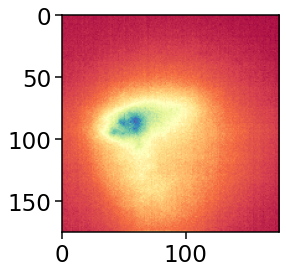

In [307]:
plt.imshow(stim_intensity)

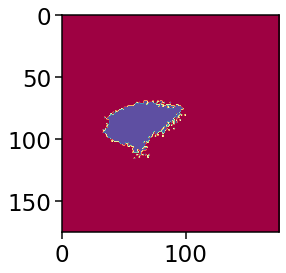

In [309]:
stim_mask = (stim_intensity > np.percentile(stim_intensity, 95)).astype(bool)
plt.imshow(stim_mask)

### Get prestim STA

In [204]:
prestim_dff = dFF_img[:np.argwhere(rising_edges).ravel()[0]-1,:,:]

In [205]:
prestim_dff_trace = images.extract_mask_trace(prestim_dff, mask=np.tile(img_mask, (prestim_dff.shape[0], 1, 1)))

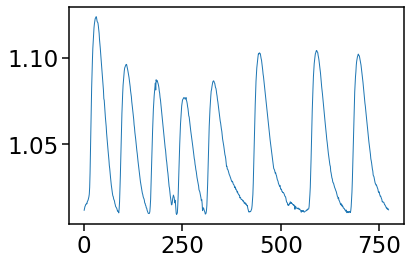

In [206]:
plt.plot(prestim_dff_trace)

In [207]:
pks, _ = signal.find_peaks(prestim_dff_trace, prominence=0.05)

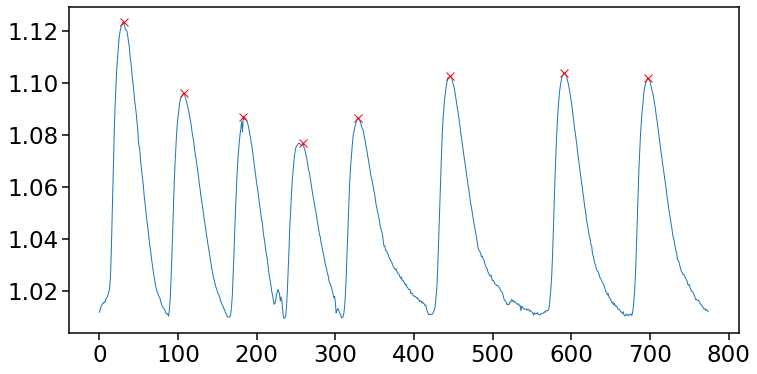

In [208]:
fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(prestim_dff_trace)
ax1.plot(pks, prestim_dff_trace[pks], "rx")

In [209]:
sta_length = 76
offset = -22
# sta_length=240
# offset=-90
spike_traces_pre = []
spike_images_pre = []
# edge = np.argwhere(falling_edges).ravel()[0]
for edge in pks:
    spike_traces_pre.append(prestim_dff_trace[edge+offset:edge+offset+sta_length])
    spike_images_pre.append(prestim_dff[edge+offset:edge+offset+sta_length,:,:])

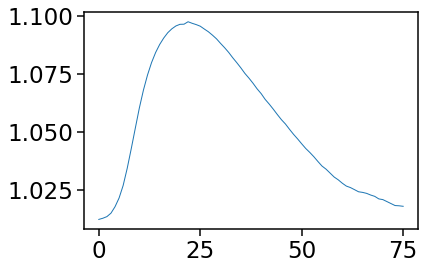

In [210]:
sta_trace_pre = np.mean(np.array(spike_traces_pre), axis=0)
plt.plot(sta_trace_pre)

In [211]:
sta_pre = np.mean(np.array(spike_images_pre), axis=0)

In [212]:
utils.display_zstack(sta_pre[:,:,:, np.newaxis], c=0, pct_cutoffs=[5,99])

interactive(children=(IntSlider(value=37, description='z', max=75), Dropdown(description='c', options=('all', …

In [181]:
skio.imsave(os.path.join(rootdir, "analysis", filename, "prestim_sta.tif"), sta_pre)

NameError: name 'sta_pre' is not defined

In [182]:
stim_sta.dtype

dtype('float64')

In [310]:
stim_mask = stim_mask.astype(float)*100
stim_mask[stim_mask==0] = np.nan

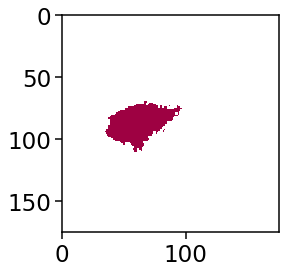

In [311]:
plt.imshow(stim_mask)

In [312]:
# stim_mask[stim_mask==0] = np.nan
stim_sta = np.tile(stim_mask, (sta.shape[0], 1, 1))
skio.imsave(os.path.join(rootdir, "analysis", filename, "stim_spot_sta.tif"), stim_sta)